In [1]:
import numpy as np
import gzip
import matplotlib.cm as cm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def read_image_database(path='data/pain_crops'):
    import os
    import imageio

    images = []
    for file in os.listdir(path):
        images.append(imageio.imread(os.path.join(path, file), as_gray=True))
    mat = np.array(images, dtype=np.uint8)
    return mat
        
# Save images
#np.savez('datäa/faces.npz', read_image_database())

# Load images
mat = np.load('data/faces.npz')['arr_0'].astype(np.float64)

# Drastically reduce the resolution
def half_resolution(X, rep=1):
    for _ in range(rep):
        r, c = 2 * (X.shape[0] // 2), 2 * (X.shape[1] // 2)
        X = 0.25 * (X[:r:2, :c:2] + X[1:r:2, 1:c:2] + X[1:r:2, :c:2] + X[:r:2, 1:c:2])
    return X

images_small = []
for i in range(mat.shape[0]):
    images_small.append(half_resolution(mat[i], 2))
mat = np.array(images_small)
X = (2.0 * mat / 255.0 - 1.0)

N = mat.shape[0]
h = mat.shape[1]
w = mat.shape[2]

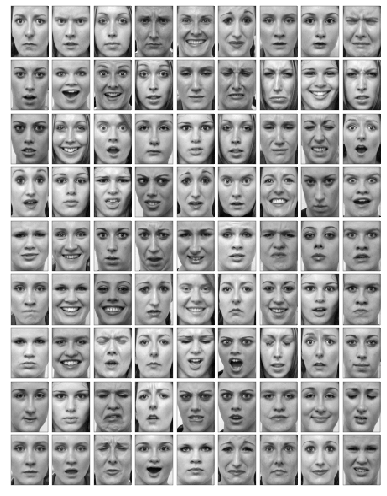

In [3]:
# Plot a picture grid
NN = int(np.floor(np.sqrt(N)))
cmap = cm.get_cmap('gray')
fig, axs = plt.subplots(NN, NN, figsize=(5.5, 7))
for i in range(NN):
    for j in range(NN):
        axs[i, j].imshow(X[NN * i + j].reshape(h, w), vmin=-1, vmax=1, cmap=cmap)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout(w_pad=0.0, h_pad=0.0)

fig.savefig('../face_database.pdf', bbox_inches='tight', transparent=True, dpi=600)

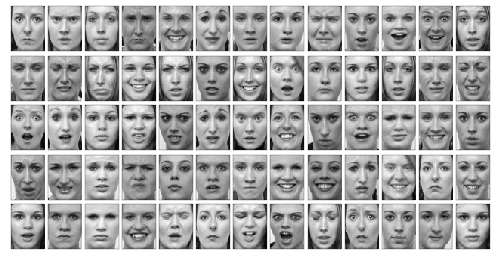

In [4]:
# Plot a picture grid
fig, axs = plt.subplots(NN - 4, NN + 4, figsize=(7, 3.75))
for i in range(NN - 4):
    for j in range(NN + 4):
        axs[i, j].imshow(X[(NN + 4) * i + j].reshape(h, w), vmin=-1, vmax=1, cmap=cmap)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout(w_pad=0.0, h_pad=0.0)

fig.savefig('../face_database_2.pdf', bbox_inches='tight', transparent=True, dpi=600)

In [5]:
# Compute the principal component vectors
X = X.reshape(N, w * h)
X_zero_mean = X - np.mean(X, axis=0)
X_cov = (X_zero_mean.T @ X_zero_mean) / (X.shape[0] - 1)
D, V = np.linalg.eigh(X_cov)
D = D[::-1]
V = V.T[::-1, :]
V = V / np.linalg.norm(V, axis=0)

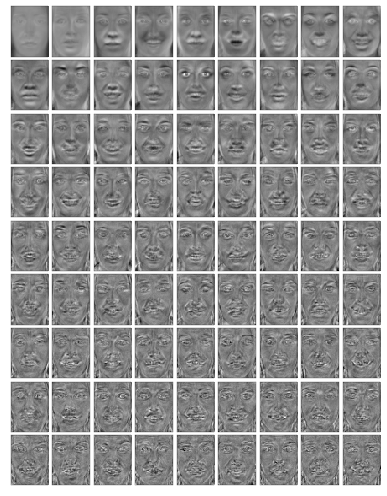

In [6]:
NN = int(np.floor(np.sqrt(N)))
cmap = cm.get_cmap('gray')
fig, axs = plt.subplots(NN, NN, figsize=(5.5, 7))
for i in range(NN):
    for j in range(NN):
        axs[i, j].imshow(V[NN * i + j].reshape(h, w), vmin=-0.125, vmax=0.125, cmap=cmap)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('../eigenfaces.pdf', bbox_inches='tight', transparent=True, dpi=600)

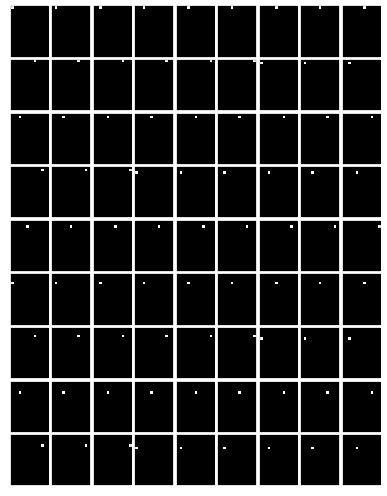

In [7]:
I = np.eye(300)
NN = int(np.floor(np.sqrt(N)))
cmap = cm.get_cmap('gray')
fig, axs = plt.subplots(NN, NN, figsize=(5.5, 7))
for i in range(NN):
    for j in range(NN):
        axs[i, j].imshow(I[NN * i + j].reshape(h // 3, w // 3), vmin=0, vmax=1, cmap=cmap)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('../eigenfaces_normal_basis.pdf', bbox_inches='tight', transparent=True, dpi=600)

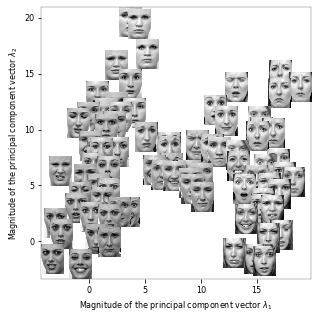

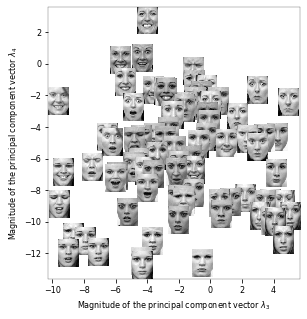

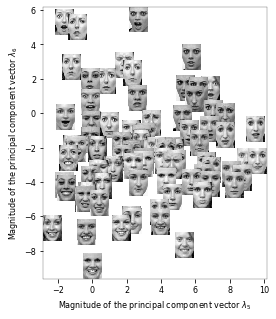

In [8]:
def plot_crosssection(dim0=0, dim1=1, scale=2.0):
    xmin, xmax = np.inf, -np.inf
    ymin, ymax = np.inf, -np.inf

    fig, ax = plt.subplots(figsize=(5.0, 5.0))
    for i in range(N):
        λ = V @ X[i]

        x0 = λ[dim0] - 0.5 * scale
        x1 = λ[dim0] + 0.5 * scale
        y0 = λ[dim1] - 0.5 * scale * h / w
        y1 = λ[dim1] + 0.5 * scale * h / w

        xmin, xmax = min(x0, xmin), max(x1, xmax)
        ymin, ymax = min(y0, ymin), max(y1, ymax)

        ax.imshow(X[i].reshape(h, w), extent=(x0, x1, y0, y1), cmap=cmap, zorder=-y0)

    ax.set_xlabel('Magnitude of the principal component vector $\\lambda_{}$'.format(dim0 + 1))
    ax.set_ylabel('Magnitude of the principal component vector $\\lambda_{}$'.format(dim1 + 1))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    return fig, ax

fig, ax = plot_crosssection(0, 1)
fig.savefig('../eigenfaces_dim_0_1.pdf', bbox_inches='tight', transparent=True, dpi=600)

fig, ax = plot_crosssection(2, 3, scale=1.3)
fig.savefig('../eigenfaces_dim_2_3.pdf', bbox_inches='tight', transparent=True, dpi=600)

fig, ax = plot_crosssection(4, 5, scale=1.1)
fig.savefig('../eigenfaces_dim_4_5.pdf', bbox_inches='tight', transparent=True, dpi=600)

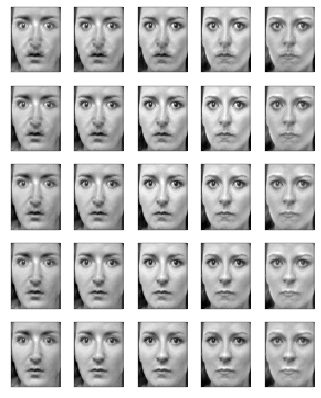

In [9]:

# Vary λ1 and λ2
steps = 5
fig, axs = plt.subplots(steps, steps, figsize=(5.5, 7))
for i, λ1 in enumerate(np.linspace(-5, 5, steps)):
    for j, λ2 in enumerate(np.linspace(-5, 5, steps)):
        # Translate one of the pictures into the eigenspace
        λ = V @ X[0]

        # Scale λ1 and λ2
        λ[5] *= λ1
        λ[6] *= λ2

        # Reconstruct the image
        X_rec = V.T @ λ

        # Plot the images
        axs[i, j].imshow(X_rec.reshape(h, w), cmap=cmap)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

fig.savefig('../face_manipulation.pdf', bbox_inches='tight', transparent=True, dpi=600)

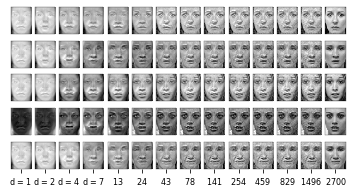

In [10]:
# Vary λ1 and λ2
steps = 14
samples = 5
fig, axs = plt.subplots(samples, steps, figsize=(6.0, 3.0))
for i in range(samples):
    for j in range(steps):
        # Translate one of the pictures into the eigenspace
        λ = V @ X[6*i]

        # Zero all but the first d vector components
        d = int(np.floor(np.power(10, np.linspace(0.1, np.log10(w * h), steps)[j])))

        λ[d:] = 0.0
        

        # Reconstruct the image
        X_rec = V.T @ λ

        # Plot the images
        axs[i, j].imshow(X_rec.reshape(h, w), cmap=cmap)
        if i != samples - 1:
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
        else:
            axs[i, j].set_xticks([w // 2])
            if d < 10:
                axs[i, j].set_xticklabels(["d = ${}$".format(d)])
            else:
                axs[i, j].set_xticklabels(["${}$".format(d)])
            axs[i, j].set_yticks([])

fig.savefig('../face_sparse.pdf', bbox_inches='tight', transparent=True, dpi=600)